In [1]:
from IPython.display import Image, display
from PIL import Image, ImageDraw, ImageFont
import PIL
from classes import *
from test_classes import *
import random
from core import *

In [2]:
fnt_pref = ImageFont.truetype('FreeMonoBold.ttf', 13)
fnt_piece = ImageFont.truetype('FreeMonoBold.ttf', 22)

def draw_pieces(pieces, perspective=None, with_text=True, startx=0, starty=0, width=900, height=30, draw_object=None):
    if draw_object == None:
        im = Image.new('RGB', (width, height), color='white')
        d = ImageDraw.Draw(im)
    else:
        d = draw_object
    background = (210,210,210)
    #Set image background
    d.rectangle((startx, starty, startx+width-1, starty+height-1), fill=background)
    
    '''
    translates an absolute cake coordinate into a screen coordinate, and also through the perspective of
    an agent's value function if that is specified
    '''
    def xcoord(x):
        if perspective==None:
            return startx + x*width
        else:
            return perspective.value_up_to(x) * width
    for p in pieces[::-1]:
        
        #draw background of pieces, and label
        for interval in p.intervals:
            left = xcoord( interval.left )
            right= xcoord( interval.right )
            d.rectangle((left,starty+1,right-1,starty+height-2), outline='black', fill=background)
            if p.allocated != None and with_text:
                if p.allocated.color:
                    d.text((right - 20, starty+ 3), str(p.allocated), fill='white', font=fnt_piece)
                    d.text((right - 19, starty+ 4), str(p.allocated), fill=p.allocated.color, font=fnt_piece)
                else:
                    d.text((right - 20, starty+ 3), str(p.allocated), fill='black', font=fnt_piece)
        
        # draw trims on pieces
        # TODO doesn't work with disjoint interval pieces
        t = p.get_rightmost_trim()
        if t != None:
            left = xcoord( p.intervals[0].left )
            #TODO better do something about this if there are multiple
            right = xcoord( t.x )
            if t.owner.color != None:
                d.rectangle((left,starty+1,right-1,starty + height-2), fill=(200,170,170))
                d.rectangle((right-2,starty+1, right, starty + height-2), fill=t.owner.color, outline=None)
            else:
                d.rectangle((left,starty+1,right-1,starty + height-2), fill=(200,170,170), outline=(200,100,100))
                
        #redraw outline, in case something went a bit outside
        for p in pieces[::-1]:
            for interval in p.intervals:
                left = xcoord( interval.left )
                right= xcoord( interval.right )
                d.rectangle((left,starty+1,right-1,starty+height-2), outline='black')
        
    if draw_object==None:
        display(im)
    
def draw_preferences(agent, with_pieces=None, width=900, height=80, pieces_height=12):
    
    im = Image.new('RGB', (width, height), color='white')
    d = ImageDraw.Draw(im)
    highest = max([agent.adv[k] for k in agent.adv])
    height_factor = (height-pieces_height) / highest
    bar_width = width / len(agent.adv)
    x=0
    if agent.color:
        fill_color = agent.color
    else:
        fill_color = (130,130,130)
    for k in agent.adv:
        d.rectangle((x, 
                     height - agent.adv[k]*height_factor,
                     x+bar_width,
                     height), 
                    fill=fill_color, 
                    outline='black')
        x += bar_width
    if agent.color:
        d.text((2, 2), str(agent), fill='black', font=fnt_piece)
        d.text((4, 4), str(agent), fill='white', font=fnt_piece)
        d.text((3, 3), str(agent), fill=agent.color, font=fnt_piece)
    else:
        d.text((3, 3), str(agent), fill='black', font=fnt_piece)
    #d.text((3, 3), str(agent) + ' preferences', fill='black', font=fnt_pref)
    if with_pieces != None:
        draw_pieces(with_pieces, with_text=False, startx=0, starty=height-pieces_height, width=width, height=pieces_height, draw_object=d)
    
    display(im)
    

In [63]:
agents = [Agent(random.randint(5,10)) for i in range(5)]
cake = Cake()
pieces = core(agents[0], agents, cake.pieces[0])

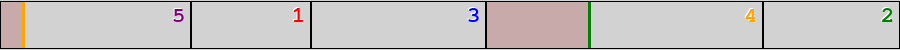

In [68]:
def visualize_1(pieces, agents, colors=['red', 'green', 'blue', 'orange', 'purple', 'magenta', 'cyan']):
    #Assign agents names and colors
    for i in range(len(agents)):
        agents[i].name = str(i+1)
        agents[i].color = colors[i]
    #Draw the main cake
    draw_pieces(pieces, height=50)
    #Draw agent preferences and their perception of the cake
    for a in agents:
        #draw_preferences(a, with_pieces=pieces)
        draw_pieces(pieces, perspective=a)
        
visualize_1(pieces, agents)

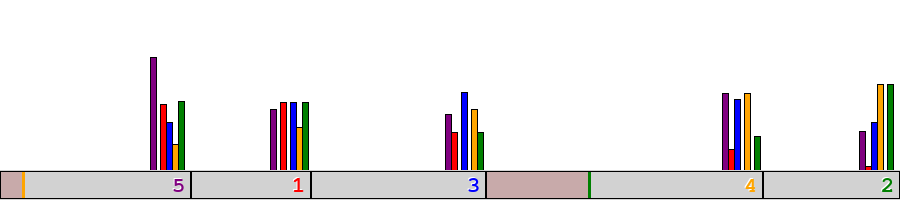

In [65]:
'''
This one places above each piece:
    The value that the owner of this piece places on all other pieces, in spacial order
'''

def draw_pieces_with_valuations1(pieces, width=900, height=200, pieces_height=12, colors=['red', 'green', 'blue', 'orange', 'purple', 'magenta', 'cyan']):
    im = Image.new('RGB', (width, height), color='white')
    d = ImageDraw.Draw(im)
    pieces_height = 30
    bar_width = 6
    bar_max_height = height - pieces_height
    separator = 4
    
    def xcoord(x):
        return x*width
    
    for i in range(len(pieces)):
        p = pieces[i]
        if (p.allocated):
                
            right = xcoord(p.intervals[-1].right)
            start_at = right - 3 - (len(pieces)*bar_width + 2*separator)
            
            current = start_at
            for i2 in range(len(pieces)):
                p2 = pieces[i2]
                whole_bar_height  = p.allocated.get_value(p2, count=False, whole_piece=True)  * bar_max_height * 2
                trimmed_bar_height= p.allocated.get_value(p2, count=False, whole_piece=False) * bar_max_height * 2
                if p2.allocated and p2.allocated.color:
                    fill_color = p2.allocated.color
                else:
                    fill_color = (130,130,130)
                d.rectangle((current, 
                             bar_max_height-trimmed_bar_height, 
                             current+bar_width, 
                             bar_max_height),
                            fill=fill_color, outline='black'
                           )
                current += bar_width
                if i2 == i or i2 == i-1:
                    current += separator
    
    #Draw the pieces below
    draw_pieces(pieces, 
                with_text=True, 
                startx=0, starty=height-pieces_height, 
                width=width, height=pieces_height, 
                draw_object=d)
    display(im)
    
draw_pieces_with_valuations1(pieces)

[[17651966757776201/83107759319334795, 18600018681673513/53815613927434830]]
[[18600018681673513/53815613927434830, 208426465454789519/385515036714337875]]
[[47704224157178773/56226695413596075, 1]]


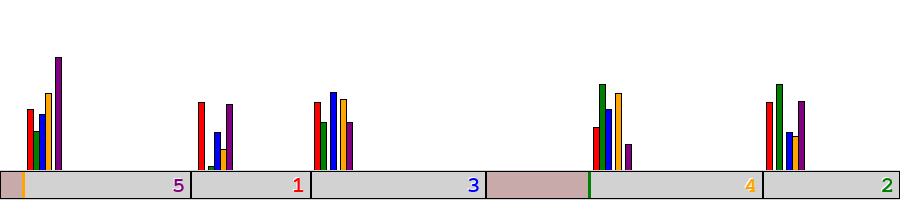

In [66]:
'''
This one places above each piece:
    The value that the lex. ordered agents place on the piece
'''

def draw_pieces_with_valuations2(pieces, agents, width=900, height=200, pieces_height=12, colors=['red', 'green', 'blue', 'orange', 'purple', 'magenta', 'cyan']):
    im = Image.new('RGB', (width, height), color='white')
    d = ImageDraw.Draw(im)
    pieces_height = 30
    bar_width = 6
    bar_max_height = height - pieces_height
    separator = 4
    
    def xcoord(x):
        return x*width
    
    for i in range(len(pieces)):
        
        p = pieces[i]
        if (p.allocated):
            t = p.get_rightmost_trim()
            if t:
                start_at = xcoord(t.x)+3
            else:
                print(p.intervals)
                start_at = xcoord(p.intervals[0].left) + 3
            
            current = start_at
            for i2 in range(len(agents)):
                a = agents[i2]
                whole_bar_height  = a.get_value(p, count=False, whole_piece=True)  * bar_max_height * 2
                trimmed_bar_height= a.get_value(p, count=False, whole_piece=False) * bar_max_height * 2
                if p.allocated == a:
                    current += separator
                if a.color:
                    fill_color = a.color
                else:
                    fill_color = (130,130,130)
                d.rectangle((current, 
                             bar_max_height-trimmed_bar_height, 
                             current+bar_width, 
                             bar_max_height),
                            fill=fill_color, outline='black'
                           )
                current += bar_width
                if p.allocated == a:
                    current += separator
    
    #Draw the pieces below
    draw_pieces(pieces, 
                with_text=True, 
                startx=0, starty=height-pieces_height, 
                width=width, height=pieces_height, 
                draw_object=d)
    display(im)
    
draw_pieces_with_valuations2(pieces, agents)

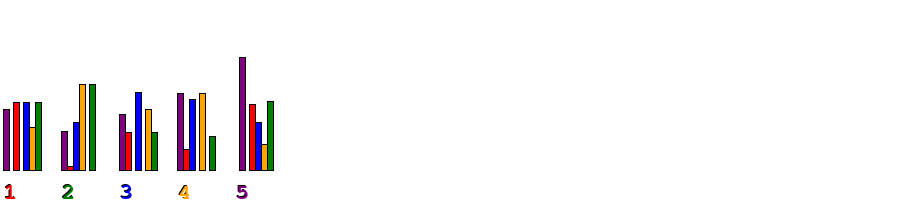

In [67]:
'''
This one places agent numbers, and valuations for each piece above the agent number
'''

def draw_agents_with_valuations(pieces, agents, width=900, height=200, pieces_height=12, colors=['red', 'green', 'blue', 'orange', 'purple', 'magenta', 'cyan']):
    im = Image.new('RGB', (width, height), color='white')
    d = ImageDraw.Draw(im)
    bar_width = 6
    separator = 4
    max_bar_height = height - 30
    
    current = 3
    for a in agents:
        d.text((current,   height-20), str(a), fill='black', font=fnt_piece)
        d.text((current+2, height-18), str(a), fill='white', font=fnt_piece)
        d.text((current+1, height-19), str(a), fill=a.color, font=fnt_piece)
        for p in pieces:
            
            if p.allocated == a:
                current += separator
                
            if p.allocated and p.allocated.color:
                fill_color = p.allocated.color
            else:
                fill_color = (130,130,130)

            whole_bar_height  = a.get_value(p, count=False, whole_piece=True)  * max_bar_height * 2
            trimmed_bar_height= a.get_value(p, count=False, whole_piece=False) * max_bar_height * 2

            d.rectangle((current, 
                         max_bar_height-trimmed_bar_height, 
                         current+bar_width, 
                         max_bar_height),
                        fill=fill_color, outline='black'
                       )
            current += bar_width
            if p.allocated == a:
                current += separator
        current += 20
    display(im)
    
draw_agents_with_valuations(pieces, agents)